In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
import itertools
import jinja2
import json
import logging
import scipy.stats

from IPython.display import HTML

logging.basicConfig(level=logging.INFO)



In [2]:
from shared_analysis import *

In [3]:
num_scenarios=4

scenario = "maximize=True_num-agents=3_belief-steps=1_belief-range=3,3_action-steps=3\
_action-range=1,101_action-function-log=False_num-scenarios=4_sample-size=68.0" ## original scenario

dfs = mturk_dfs(scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

condition = 'Area'

# We only have the `none` scenario here
df_none = None
for df in dfs:
    if df.name == condition:
        df_none = df
        break

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


In [4]:
normalize = True
values = {}
table = {}
lower_errors = {}
upper_errors = {}
between=('scenario_nbs', 'scenario_fehr')
names = {'scenario_nbs' : 'Nash Product', 'scenario_fehr' : 'Inequality Sum'}

proportion_disagree = []

for function in between:
    values[function] = []
    lower_errors[function] = []
    upper_errors[function] = []

values["both"] = []
lower_errors["both"] = []
upper_errors["both"] = []


x = np.arange(0, 1.1, .1)

for i in x:
    if 'scenario_fehr' in df:
        del df['scenario_fehr']
    df = add_fehr(df, alpha=i)
    n = len(df)
    agreements = not_null_ties(control(df, between))
    disagreements = test(df, between)

    table[f"{i:.1f}"] = {}
    table[f"{i:.1f}"]['# disagreements'] = len(disagreements)
    table[f"{i:.1f}"]['# agreements'] = len(agreements)
    table[f"{i:.1f}"]['ratio'] = f"{len(agreements) / len(disagreements) if len(disagreements) > 0 else 0:.2f}"
    
    proportion_disagree.append(len(disagreements) / len(agreements))

    for function in between:
        datum, (low, high) = function_success(disagreements, normalize=normalize, function=function)
        values[function].append(datum)
        lower_errors[function].append(low)
        upper_errors[function].append(high)

    function = "both"
    datum, (low, high) = control_success(agreements, normalize=normalize, between=between)
    values[function].append(datum)
    lower_errors[function].append(low)
    upper_errors[function].append(high)


In [5]:
print(pd.DataFrame(table).T.to_latex())

\begin{tabular}{llll}
\toprule
 & # disagreements & # agreements & ratio \\
\midrule
0.0 & 216 & 120 & 0.56 \\
0.1 & 96 & 240 & 2.50 \\
0.2 & 0 & 336 & 0.00 \\
0.3 & 0 & 336 & 0.00 \\
0.4 & 24 & 312 & 13.00 \\
0.5 & 72 & 264 & 3.67 \\
0.6 & 72 & 264 & 3.67 \\
0.7 & 96 & 240 & 2.50 \\
0.8 & 96 & 240 & 2.50 \\
0.9 & 96 & 240 & 2.50 \\
1.0 & 72 & 120 & 1.67 \\
\bottomrule
\end{tabular}



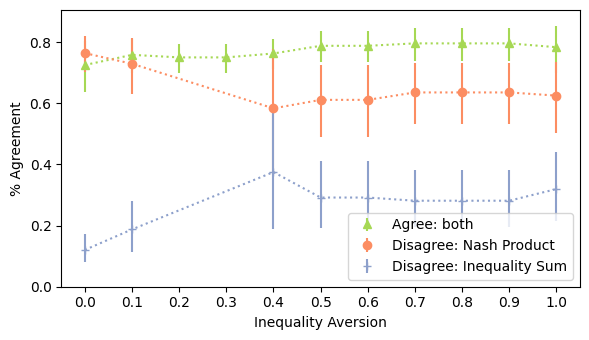

In [6]:
with plt.rc_context({'font.size': 10}):
    fig, ax1 = plt.subplots(figsize=(6, 3.5))
    
    # Plotting lines with error bars and dotted line
    # for function in between:
    #     ax1.errorbar(x, values[function], yerr=[lower_errors[function], upper_errors[function]],
    #                  fmt='o', color=AGGREGATION_TO_COLOR[function], label="Disagree: " + names[function])
    #     ax1.plot(x, values[function], linestyle=':', color=AGGREGATION_TO_COLOR[function])
    
    
    # Agreement cases
    function = "both"
    ax1.errorbar(x, values[function], yerr=[lower_errors[function], upper_errors[function]],
                 fmt='^', color=CONDITION_TO_COLOR[condition], label="Agree: both")
    ax1.plot(x, values[function], linestyle=':', color=CONDITION_TO_COLOR[condition])

    x_cutoff = np.concatenate((x[:2], x[4:]))
    symbols = ['o', '+']
    for function, symbol in zip(['scenario_nbs', 'scenario_fehr'], symbols):
        # Plot the dots with error bars
        ax1.errorbar(x_cutoff, values[function][:2] +  values[function][4:] ,
                     yerr=[lower_errors[function][:2] + lower_errors[function][4:],
                           upper_errors[function][:2] + upper_errors[function][4:]],
                     fmt=symbol, color=AGGREGATION_TO_COLOR[function], label="Disagree: " + names[function])
        # Plot the lines without the masked ranges
        ax1.plot(x_cutoff, values[function][:2] +  values[function][4:] , linestyle=':', color=AGGREGATION_TO_COLOR[function])
    
    # Adding labels and title
    ax1.set_xlabel('Inequality Aversion')
    ax1.set_ylabel('% Agreement')
    # ax1.set_title('Comparing the Nash Product and Parameterized Inequality Sum')
    ax1.legend(loc='lower right')
    
    # Setting x-axis ticks at every tenth
    ax1.set_xticks(x)
    ax1.set_ylim(0, .905)
    
    # # Create a secondary y-axis
    # ax2 = ax1.twinx()
    
    # # Sample data for the secondary y-axis
    
    # # Plotting the secondary y-axis data
    # ax2.plot(x, proportion_disagree, 'o-', color='lightgrey', label='# disagree /\n# agree')
    # ax2.set_ylabel('Ratio')
    # ax2.set_ylim(0, 1.8)
    # ax2.legend(loc='upper right')
    
    # Display the plot
    fig.tight_layout()
    
    save_fig(fig, name="nash_inequality_aversion_area")
    plt.show()
